# 8 Pilares Estadisticos: Evaluacion de Inflacion

**Traduciendo conceptos academicos para Data Science al mundo real**

Este notebook evalua los datos de Inflacion procesados por `ETL_Principales.py`, aplicando los 8 pilares estadisticos:

1. **Distribuciones** - Forma de los datos
2. **Centro de Gravedad** - Media, Mediana, Moda
3. **Fiabilidad** - Riesgo y volatilidad
4. **Margen de Error** - Intervalos de confianza
5. **Pruebas de Hipotesis** - Chi-cuadrada
6. **Regresion/Prediccion** - Machine Learning
7. **Series de Tiempo** - Tendencias y estacionalidad
8. **ANOVA** - Comparacion entre grupos

**Variables principales:**
- INPC (Indice Nacional de Precios al Consumidor)
- Inflacion interanual (YoY)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, normaltest, kruskal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

BASE_DIR = Path('..').resolve()
DATOS_RESULTADO = BASE_DIR / 'Datos_Resultado'
print(f"Directorio base: {BASE_DIR}")

Directorio base: C:\Users\ARTUROJF\Desktop\Final


## Carga de Datos

In [2]:
path_datos = DATOS_RESULTADO / 'Inflacion_Trimestral.csv'
df = pd.read_csv(path_datos) if path_datos.exists() else pd.DataFrame()

print(f"Datos: {len(df)} filas x {len(df.columns)} columnas")
print(f"Columnas: {df.columns.tolist()}")
df.head(10)

Datos: 219 filas x 7 columnas
Columnas: ['periodo', 'year', 'quarter', 'inpc_q_eoq', 'inpc_q_avg', 'inflacion_yoy_eoq', 'inflacion_yoy_avg']


,periodo,year,quarter,inpc_q_eoq,inpc_q_avg,inflacion_yoy_eoq,inflacion_yoy_avg
0,1971-01-01,1971,1,0.0129,0.0129,5.47,5.26
1,1971-04-01,1971,2,0.0131,0.0130,5.71,5.82
2,1971-07-01,1971,3,0.0132,0.0131,5.67,5.46
3,1971-10-01,1971,4,0.0133,0.0133,4.96,5.35
4,1972-01-01,1972,1,0.0135,0.0134,4.46,4.38
5,1972-04-01,1972,2,0.0137,0.0136,4.87,4.68
6,1972-07-01,1972,3,0.0139,0.0138,5.22,5.21
7,1972-10-01,1972,4,0.0140,0.0140,5.56,5.48
8,1973-01-01,1973,1,0.0145,0.0144,7.52,7.10
9,1973-04-01,1973,2,0.0150,0.0149,9.56,9.19


In [3]:
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.sort_values('periodo').reset_index(drop=True)
df['TRIMESTRE'] = df['quarter'] if 'quarter' in df.columns else df['periodo'].dt.quarter
if 'year' not in df.columns:
    df['year'] = df['periodo'].dt.year

cols_numericas = ['inpc_q_eoq', 'inpc_q_avg', 'inflacion_yoy_eoq', 'inflacion_yoy_avg']
cols_numericas = [c for c in cols_numericas if c in df.columns]

VAR_PRINCIPAL = 'inflacion_yoy_eoq'
print(f"Variable principal: {VAR_PRINCIPAL}")
print(f"Rango: {df[VAR_PRINCIPAL].min():.2f}% a {df[VAR_PRINCIPAL].max():.2f}%")
print(f"Periodo: {df['periodo'].min()} a {df['periodo'].max()}")
df[cols_numericas].describe()

Variable principal: inflacion_yoy_eoq
Rango: 2.13% a 175.83%
Periodo: 1971-01-01 00:00:00 a 2025-07-01 00:00:00


,inpc_q_eoq,inpc_q_avg,inflacion_yoy_eoq,inflacion_yoy_avg
count,219.000000,219.000000,219.000000,219.000000
mean,44.042519,43.826144,21.324977,21.318219
std,43.270988,43.139494,30.255740,30.190018
min,0.012900,0.012900,2.130000,2.270000
25%,0.443700,0.428900,4.380000,4.405000
50%,36.034400,35.660000,7.820000,7.770000
75%,78.103050,77.675350,23.275000,23.895000
max,140.867000,140.823500,175.830000,177.440000


---
## PILAR 1: Distribuciones

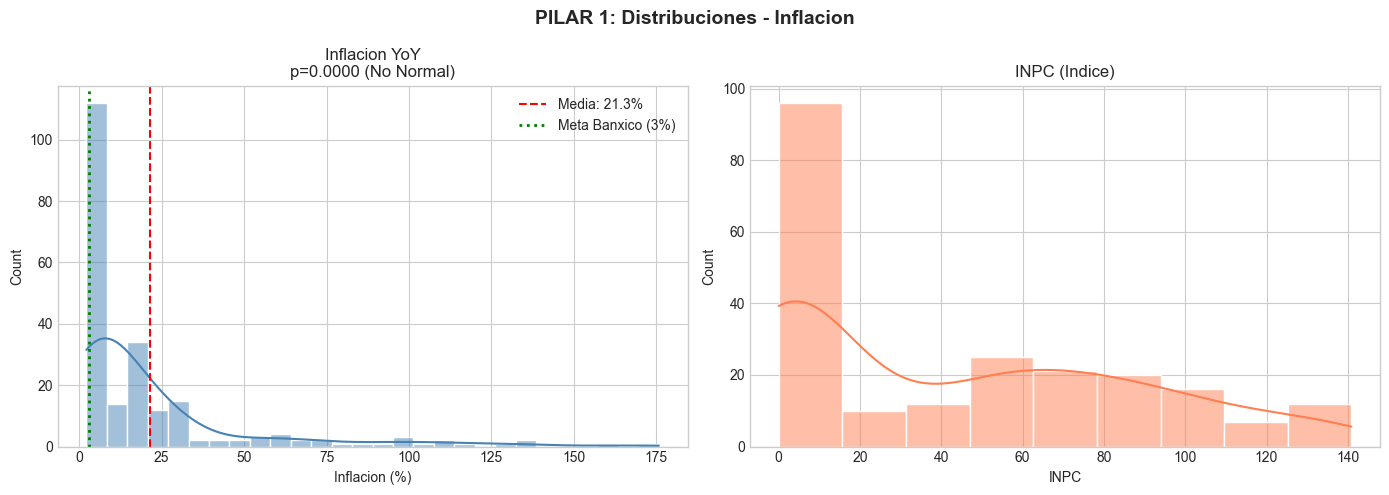


RESUMEN DE NORMALIDAD:
inpc_q_eoq           | p=0.0000 | No Normal
inpc_q_avg           | p=0.0000 | No Normal
inflacion_yoy_eoq    | p=0.0000 | No Normal
inflacion_yoy_avg    | p=0.0000 | No Normal


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 1: Distribuciones - Inflacion', fontsize=14, fontweight='bold')

# Inflacion YoY
data = df[VAR_PRINCIPAL].dropna()
sns.histplot(data, kde=True, ax=axes[0], color='steelblue', edgecolor='white')
if len(data) >= 20:
    _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
    axes[0].set_title(f'Inflacion YoY\np={p:.4f} ({"Normal" if p > 0.05 else "No Normal"})')
axes[0].axvline(data.mean(), color='red', linestyle='--', label=f'Media: {data.mean():.1f}%')
axes[0].axvline(3, color='green', linestyle=':', linewidth=2, label='Meta Banxico (3%)')
axes[0].set_xlabel('Inflacion (%)')
axes[0].legend()

# INPC
if 'inpc_q_eoq' in df.columns:
    data2 = df['inpc_q_eoq'].dropna()
    sns.histplot(data2, kde=True, ax=axes[1], color='coral', edgecolor='white')
    axes[1].set_title('INPC (Indice)')
    axes[1].set_xlabel('INPC')

plt.tight_layout()
plt.show()

print("\nRESUMEN DE NORMALIDAD:")
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 20:
        _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        print(f"{var:20} | p={p:.4f} | {'Normal' if p > 0.05 else 'No Normal'}")

---
## PILAR 2: Centro de Gravedad

In [5]:
print("PILAR 2: MEDIDAS DE TENDENCIA CENTRAL")
print("="*60)

stats_centro = []
for var in cols_numericas:
    data = df[var].dropna()
    stats_centro.append({
        'Variable': var,
        'Media': data.mean(),
        'Mediana': data.median(),
        'Desv. Std': data.std(),
        'Min': data.min(),
        'Max': data.max()
    })

pd.DataFrame(stats_centro)

PILAR 2: MEDIDAS DE TENDENCIA CENTRAL


,Variable,Media,Mediana,Desv. Std,Min,Max
0,inpc_q_eoq,44.042519,36.0344,43.270988,0.0129,140.8670
1,inpc_q_avg,43.826144,35.6600,43.139494,0.0129,140.8235
2,inflacion_yoy_eoq,21.324977,7.8200,30.255740,2.1300,175.8300
3,inflacion_yoy_avg,21.318219,7.7700,30.190018,2.2700,177.4400


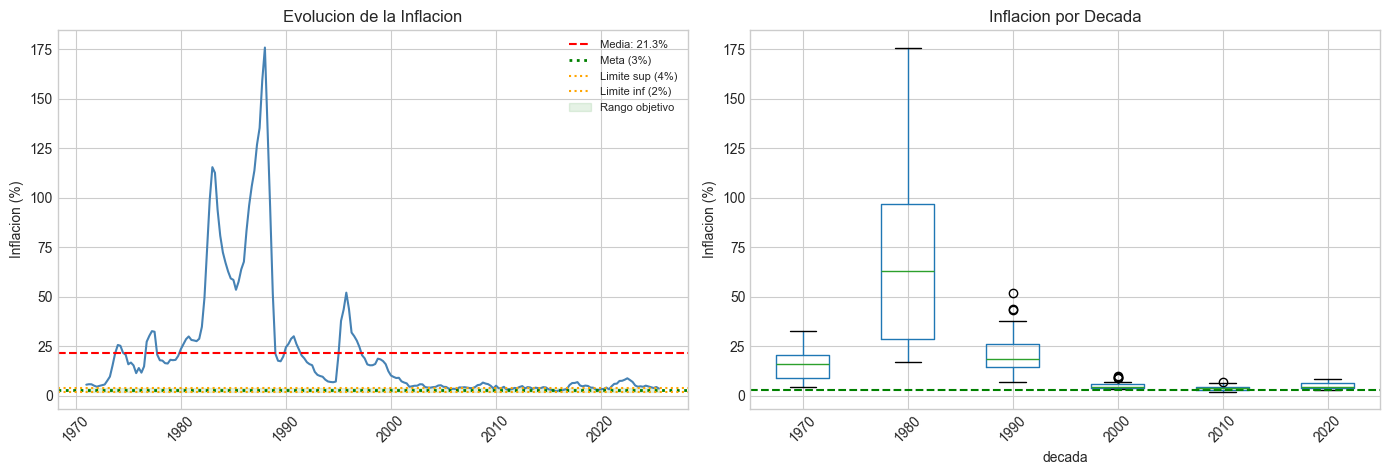

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 2: Centro de Gravedad', fontsize=14, fontweight='bold')

# Evolucion inflacion
axes[0].plot(df['periodo'], df[VAR_PRINCIPAL], color='steelblue', linewidth=1.5)
axes[0].axhline(df[VAR_PRINCIPAL].mean(), color='red', linestyle='--', label=f'Media: {df[VAR_PRINCIPAL].mean():.1f}%')
axes[0].axhline(3, color='green', linestyle=':', linewidth=2, label='Meta (3%)')
axes[0].axhline(4, color='orange', linestyle=':', label='Limite sup (4%)')
axes[0].axhline(2, color='orange', linestyle=':', label='Limite inf (2%)')
axes[0].fill_between(df['periodo'], 2, 4, alpha=0.1, color='green', label='Rango objetivo')
axes[0].set_ylabel('Inflacion (%)')
axes[0].set_title('Evolucion de la Inflacion')
axes[0].legend(fontsize=8)
axes[0].tick_params(axis='x', rotation=45)

# Boxplot por decada
df['decada'] = (df['year'] // 10) * 10
df.boxplot(column=VAR_PRINCIPAL, by='decada', ax=axes[1])
axes[1].axhline(3, color='green', linestyle='--', label='Meta')
axes[1].set_title('Inflacion por Decada')
axes[1].set_ylabel('Inflacion (%)')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

---
## PILAR 3: Fiabilidad

In [7]:
print("PILAR 3: FIABILIDAD Y VOLATILIDAD")
print("="*60)

data = df[VAR_PRINCIPAL].dropna()
cv = data.std() / data.mean() * 100
Q1, Q3 = data.quantile([0.25, 0.75])
IQR = Q3 - Q1
outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()

print(f"Coeficiente de Variacion: {cv:.1f}%")
print(f"IQR: {IQR:.2f}")
print(f"Outliers: {outliers} ({outliers/len(data)*100:.1f}%)")

# Periodos fuera de rango objetivo
fuera_rango = ((data < 2) | (data > 4)).sum()
print(f"\nPeriodos fuera de rango 2-4%: {fuera_rango} ({fuera_rango/len(data)*100:.1f}%)")

PILAR 3: FIABILIDAD Y VOLATILIDAD
Coeficiente de Variacion: 141.9%
IQR: 18.89
Outliers: 27 (12.3%)

Periodos fuera de rango 2-4%: 181 (82.6%)


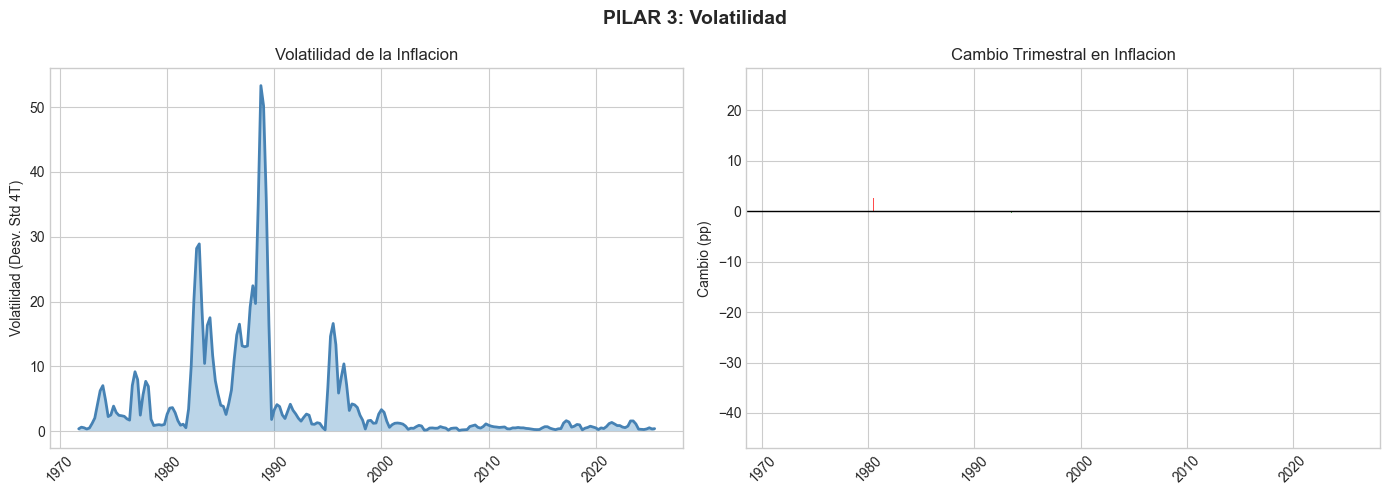

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 3: Volatilidad', fontsize=14, fontweight='bold')

# Rolling volatilidad
vol = df[VAR_PRINCIPAL].rolling(4).std()
axes[0].plot(df['periodo'], vol, color='steelblue', linewidth=2)
axes[0].fill_between(df['periodo'], vol, alpha=0.3)
axes[0].set_ylabel('Volatilidad (Desv. Std 4T)')
axes[0].set_title('Volatilidad de la Inflacion')
axes[0].tick_params(axis='x', rotation=45)

# Cambio trimestral
cambio = df[VAR_PRINCIPAL].diff()
colors = ['green' if x < 0 else 'red' for x in cambio]
axes[1].bar(df['periodo'], cambio, color=colors, alpha=0.7)
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_ylabel('Cambio (pp)')
axes[1].set_title('Cambio Trimestral en Inflacion')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 4: Margen de Error

In [9]:
print("PILAR 4: INTERVALOS DE CONFIANZA (95%)")
print("="*60)

def ic(data, conf=0.95):
    n = len(data)
    m = data.mean()
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + conf) / 2, n - 1)
    return m - h, m + h, h

for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 10:
        low, high, margin = ic(data)
        print(f"{var:20}: {data.mean():.2f} [{low:.2f}, {high:.2f}] +/-{margin:.2f}")

PILAR 4: INTERVALOS DE CONFIANZA (95%)
inpc_q_eoq          : 44.04 [38.28, 49.81] +/-5.76
inpc_q_avg          : 43.83 [38.08, 49.57] +/-5.75
inflacion_yoy_eoq   : 21.32 [17.30, 25.35] +/-4.03
inflacion_yoy_avg   : 21.32 [17.30, 25.34] +/-4.02


---
## PILAR 5: Pruebas de Hipotesis

In [10]:
print("PILAR 5: PRUEBAS DE HIPOTESIS")
print("="*60)

# Categorizar inflacion
df_test = df.copy()
df_test['infl_cat'] = pd.cut(df_test[VAR_PRINCIPAL], 
                              bins=[-np.inf, 2, 4, 10, np.inf], 
                              labels=['Baja (<2%)', 'Meta (2-4%)', 'Alta (4-10%)', 'Muy Alta (>10%)'])

# H1: Inflacion vs Trimestre
print("\n--- H1: Nivel Inflacion vs Trimestre ---")
contingencia = pd.crosstab(df_test['infl_cat'], df_test['TRIMESTRE'])
print(contingencia)

if contingencia.shape[0] > 1 and contingencia.shape[1] > 1:
    chi2, p_value, _, _ = chi2_contingency(contingencia)
    print(f"\nChi2={chi2:.4f}, p={p_value:.4f}")
    print(f"{'RECHAZAR H0' if p_value < 0.05 else 'NO RECHAZAR H0'}")
else:
    p_value = 1.0

PILAR 5: PRUEBAS DE HIPOTESIS

--- H1: Nivel Inflacion vs Trimestre ---
TRIMESTRE         1   2   3   4
infl_cat                       
Meta (2-4%)       9   9   9  11
Alta (4-10%)     20  22  21  18
Muy Alta (>10%)  26  24  25  25

Chi2=0.8193, p=0.9915
NO RECHAZAR H0


In [11]:
# H2: Inflacion pre/post 2000
print("\n--- H2: Inflacion Pre/Post 2000 ---")
df_test['era'] = df_test['year'].apply(lambda x: 'Pre-2000' if x < 2000 else 'Post-2000')

contingencia2 = pd.crosstab(df_test['infl_cat'], df_test['era'])
print(contingencia2)

if contingencia2.shape[0] > 1 and contingencia2.shape[1] > 1:
    chi2_2, p_value_2, _, _ = chi2_contingency(contingencia2)
    print(f"\nChi2={chi2_2:.4f}, p={p_value_2:.6f}")
else:
    p_value_2 = 1.0


--- H2: Inflacion Pre/Post 2000 ---
era              Post-2000  Pre-2000
infl_cat                            
Meta (2-4%)             38         0
Alta (4-10%)            64        17
Muy Alta (>10%)          1        99

Chi2=161.1076, p=0.000000


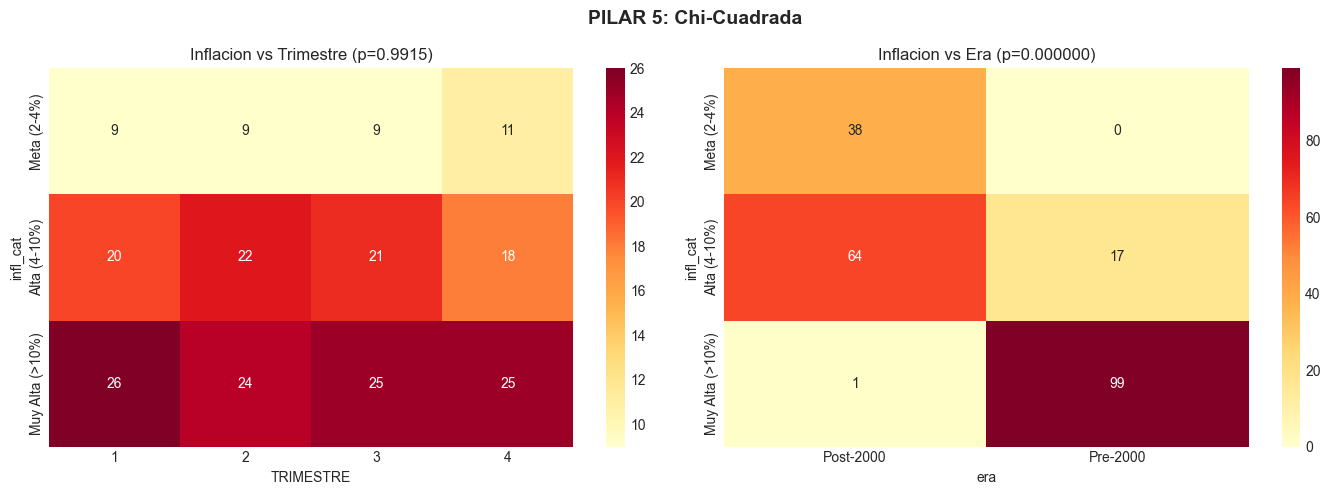

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 5: Chi-Cuadrada', fontsize=14, fontweight='bold')

sns.heatmap(contingencia, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0])
axes[0].set_title(f'Inflacion vs Trimestre (p={p_value:.4f})')

sns.heatmap(contingencia2, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1])
axes[1].set_title(f'Inflacion vs Era (p={p_value_2:.6f})')

plt.tight_layout()
plt.show()

---
## PILAR 6: Prediccion ML

In [13]:
print("PILAR 6: MACHINE LEARNING")
print("="*60)

# Features: lags de inflacion
df_ml = df.copy()
df_ml['infl_lag1'] = df_ml[VAR_PRINCIPAL].shift(1)
df_ml['infl_lag2'] = df_ml[VAR_PRINCIPAL].shift(2)
df_ml['infl_lag4'] = df_ml[VAR_PRINCIPAL].shift(4)
df_ml['inpc_change'] = df_ml['inpc_q_eoq'].pct_change() * 100 if 'inpc_q_eoq' in df_ml.columns else 0

features = ['infl_lag1', 'infl_lag2', 'infl_lag4', 'TRIMESTRE', 'year']
features = [f for f in features if f in df_ml.columns]
target = VAR_PRINCIPAL

df_ml = df_ml[features + [target]].dropna()
X = df_ml[features]
y = df_ml[target]

print(f"Features: {features}")
print(f"Observaciones: {len(df_ml)}")

if len(df_ml) >= 20:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

PILAR 6: MACHINE LEARNING
Features: ['infl_lag1', 'infl_lag2', 'infl_lag4', 'TRIMESTRE', 'year']
Observaciones: 215


In [14]:
if len(df_ml) >= 20:
    modelos = {
        'Regresion Lineal': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    resultados = []
    predicciones = {}
    
    for nombre, modelo in modelos.items():
        if 'Forest' in nombre or 'Boosting' in nombre:
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
        else:
            modelo.fit(X_train_scaled, y_train)
            y_pred = modelo.predict(X_test_scaled)
        
        resultados.append({
            'Modelo': nombre,
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        })
        predicciones[nombre] = y_pred
    
    df_resultados = pd.DataFrame(resultados).sort_values('R2', ascending=False)
    print(df_resultados.to_string(index=False))
    mejor_modelo = df_resultados.iloc[0]['Modelo']
    print(f"\n*** MEJOR: {mejor_modelo} (R2={df_resultados.iloc[0]['R2']:.4f}) ***")
else:
    print("Datos insuficientes")
    mejor_modelo = 'N/A'
    df_resultados = pd.DataFrame()

           Modelo      RMSE      MAE       R2
 Regresion Lineal  3.449482 2.043887 0.978442
            Ridge  5.858292 2.713964 0.937821
Gradient Boosting 11.798113 3.824034 0.747812
    Random Forest 11.899886 3.769647 0.743442

*** MEJOR: Regresion Lineal (R2=0.9784) ***


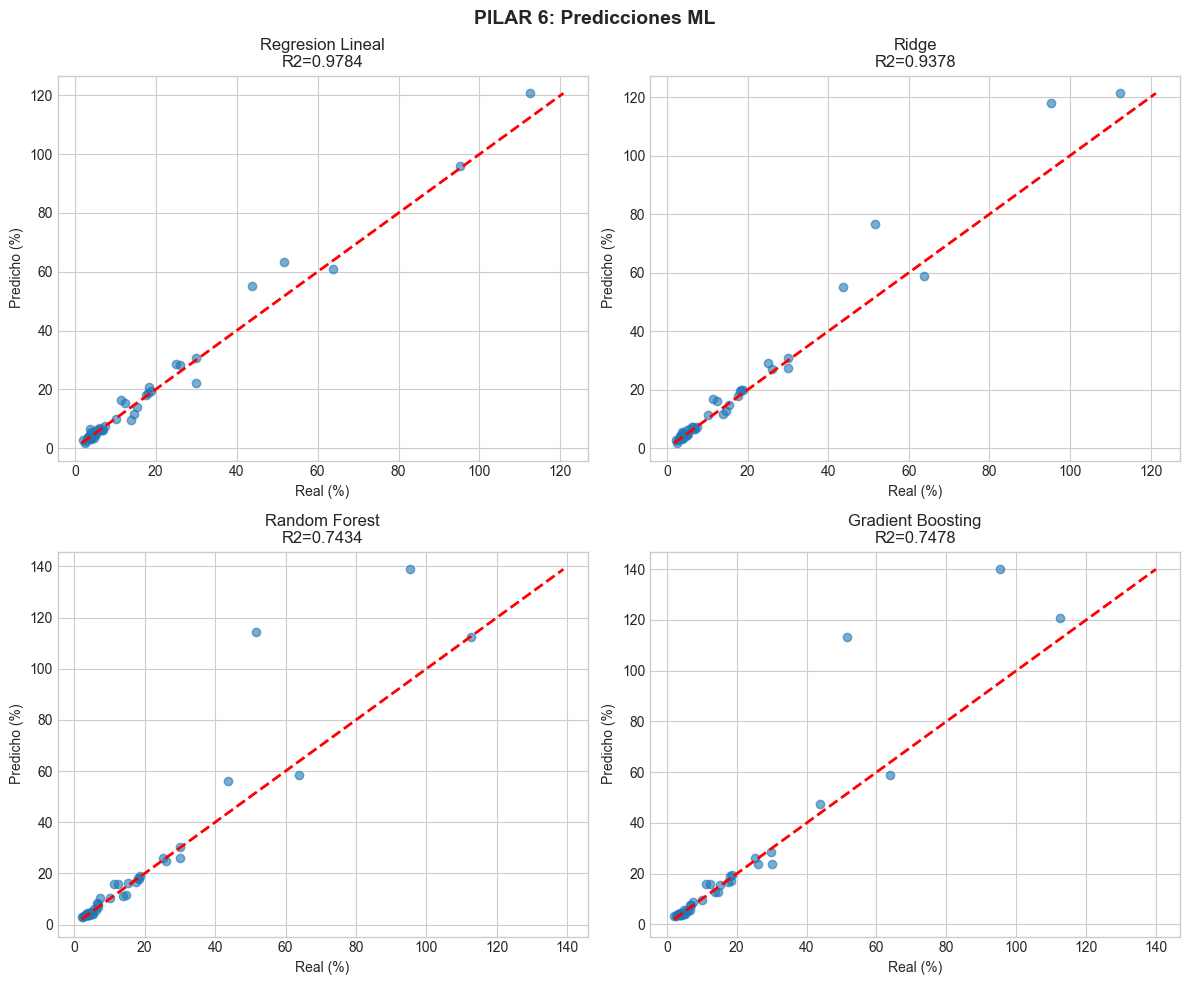

In [15]:
if len(df_ml) >= 20:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('PILAR 6: Predicciones ML', fontsize=14, fontweight='bold')
    
    for idx, (nombre, y_pred) in enumerate(predicciones.items()):
        ax = axes[idx // 2, idx % 2]
        ax.scatter(y_test, y_pred, alpha=0.6)
        lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
        ax.plot(lims, lims, 'r--', linewidth=2)
        ax.set_xlabel('Real (%)')
        ax.set_ylabel('Predicho (%)')
        ax.set_title(f'{nombre}\nR2={r2_score(y_test, y_pred):.4f}')
    
    plt.tight_layout()
    plt.show()

---
## PILAR 7: Series de Tiempo

In [16]:
print("PILAR 7: SERIES DE TIEMPO")
print("="*60)

ts_data = df.set_index('periodo')[VAR_PRINCIPAL].dropna().asfreq('QS')
print(f"Serie: {ts_data.index.min()} a {ts_data.index.max()}")

adf_result = adfuller(ts_data.dropna())
print(f"\nTest ADF: stat={adf_result[0]:.4f}, p={adf_result[1]:.4f}")
print(f"{'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")

PILAR 7: SERIES DE TIEMPO
Serie: 1971-01-01 00:00:00 a 2025-07-01 00:00:00

Test ADF: stat=-1.7205, p=0.4206
NO ESTACIONARIA


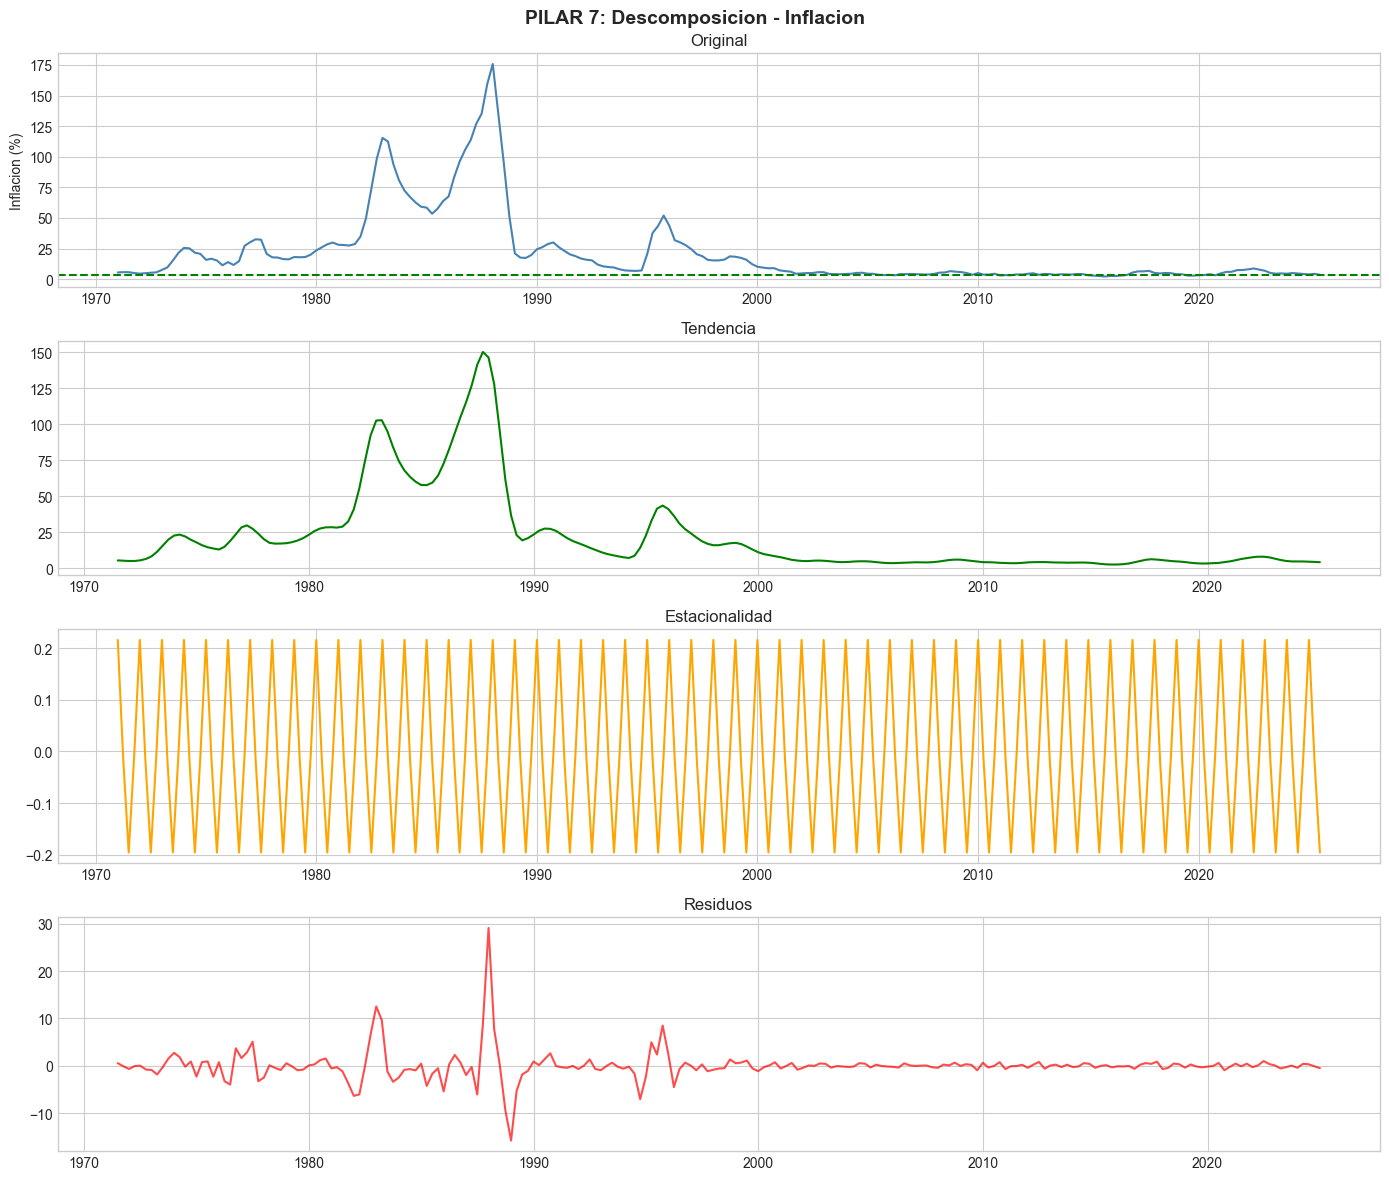

In [17]:
if len(ts_data.dropna()) >= 8:
    decomp = seasonal_decompose(ts_data.dropna(), model='additive', period=4)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('PILAR 7: Descomposicion - Inflacion', fontsize=14, fontweight='bold')
    
    axes[0].plot(ts_data, color='steelblue')
    axes[0].axhline(3, color='green', linestyle='--')
    axes[0].set_title('Original')
    axes[0].set_ylabel('Inflacion (%)')
    
    axes[1].plot(decomp.trend, color='green')
    axes[1].set_title('Tendencia')
    
    axes[2].plot(decomp.seasonal, color='orange')
    axes[2].set_title('Estacionalidad')
    
    axes[3].plot(decomp.resid, color='red', alpha=0.7)
    axes[3].set_title('Residuos')
    
    plt.tight_layout()
    plt.show()

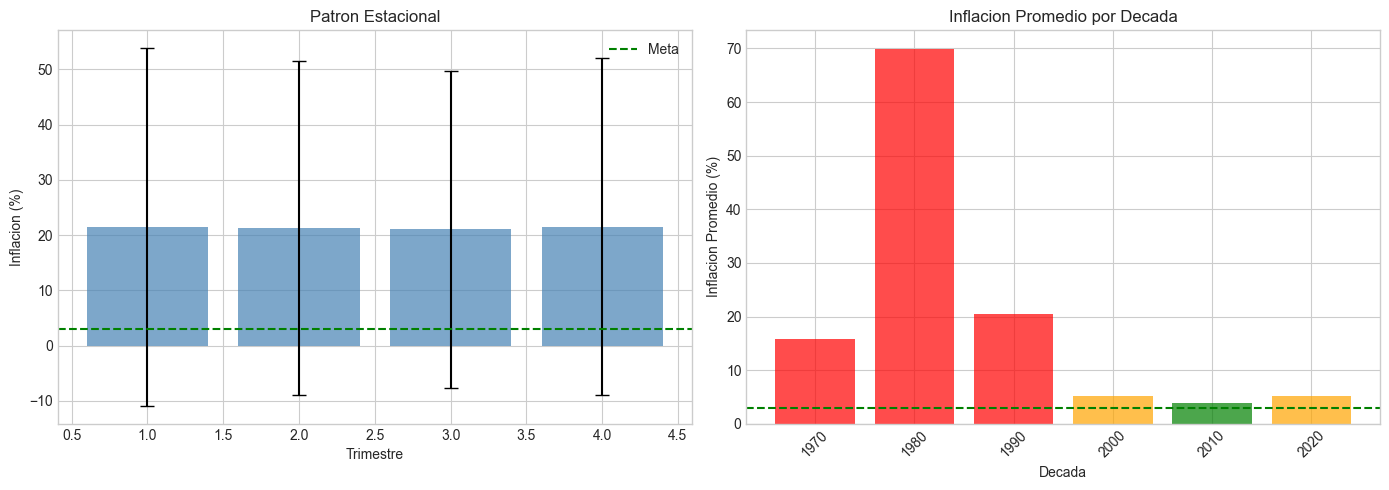

In [18]:
# Patron por trimestre y decada
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

patron = df.groupby('TRIMESTRE')[VAR_PRINCIPAL].agg(['mean', 'std'])
axes[0].bar(patron.index, patron['mean'], yerr=patron['std'], capsize=5, color='steelblue', alpha=0.7)
axes[0].axhline(3, color='green', linestyle='--', label='Meta')
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Inflacion (%)')
axes[0].set_title('Patron Estacional')
axes[0].legend()

# Promedio por decada
prom_dec = df.groupby('decada')[VAR_PRINCIPAL].mean()
colors = ['red' if v > 10 else 'orange' if v > 4 else 'green' for v in prom_dec]
axes[1].bar(prom_dec.index.astype(str), prom_dec.values, color=colors, alpha=0.7)
axes[1].axhline(3, color='green', linestyle='--', label='Meta')
axes[1].set_xlabel('Decada')
axes[1].set_ylabel('Inflacion Promedio (%)')
axes[1].set_title('Inflacion Promedio por Decada')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 8: ANOVA

In [19]:
print("PILAR 8: ANOVA")
print("="*60)

# Por trimestre
grupos = [df[df['TRIMESTRE'] == t][VAR_PRINCIPAL].dropna() for t in [1, 2, 3, 4]]
grupos = [g for g in grupos if len(g) >= 3]

if len(grupos) >= 2:
    f_stat, p_anova = stats.f_oneway(*grupos)
    print(f"Por Trimestre: F={f_stat:.4f}, p={p_anova:.4f}")
else:
    f_stat, p_anova = 0, 1.0

# Por decada
grupos_dec = [df[df['decada'] == d][VAR_PRINCIPAL].dropna() for d in df['decada'].unique()]
grupos_dec = [g for g in grupos_dec if len(g) >= 3]

if len(grupos_dec) >= 2:
    f_stat2, p_anova2 = stats.f_oneway(*grupos_dec)
    print(f"Por Decada: F={f_stat2:.4f}, p={p_anova2:.6f}")
else:
    f_stat2, p_anova2 = 0, 1.0

PILAR 8: ANOVA
Por Trimestre: F=0.0031, p=0.9998
Por Decada: F=69.6991, p=0.000000


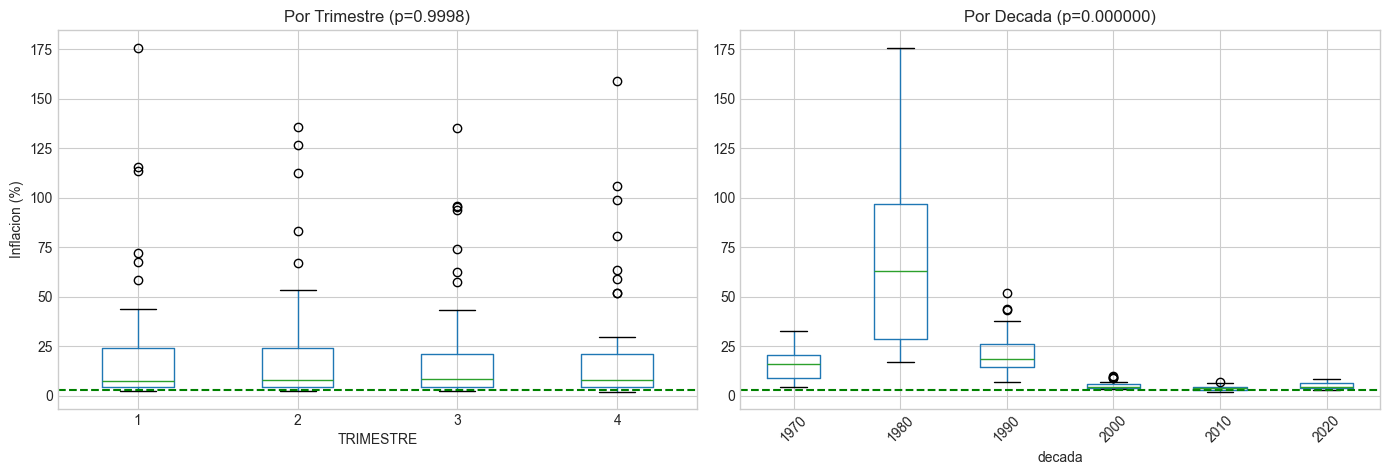

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 8: ANOVA', fontsize=14, fontweight='bold')

df.boxplot(column=VAR_PRINCIPAL, by='TRIMESTRE', ax=axes[0])
axes[0].axhline(3, color='green', linestyle='--')
axes[0].set_title(f'Por Trimestre (p={p_anova:.4f})')
axes[0].set_ylabel('Inflacion (%)')
plt.suptitle('')

df.boxplot(column=VAR_PRINCIPAL, by='decada', ax=axes[1])
axes[1].axhline(3, color='green', linestyle='--')
axes[1].set_title(f'Por Decada (p={p_anova2:.6f})')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

---
## RESUMEN EJECUTIVO

In [21]:
print("="*70)
print("RESUMEN: 8 PILARES - INFLACION")
print("="*70)

print(f"\n1. DISTRIBUCIONES: No Normal (sesgo por periodos de alta inflacion)")

print(f"\n2. CENTRO DE GRAVEDAD:")
print(f"   - Inflacion Media Historica: {df[VAR_PRINCIPAL].mean():.2f}%")
print(f"   - Inflacion Mediana: {df[VAR_PRINCIPAL].median():.2f}%")
print(f"   - Inflacion Actual: {df[VAR_PRINCIPAL].iloc[-1]:.2f}%")

print(f"\n3. FIABILIDAD:")
print(f"   - CV: {cv:.1f}%")
print(f"   - Periodos en meta (2-4%): {((df[VAR_PRINCIPAL] >= 2) & (df[VAR_PRINCIPAL] <= 4)).sum()} de {len(df)}")

print(f"\n4. MARGEN DE ERROR: Ver IC arriba")

print(f"\n5. CHI-CUADRADA:")
print(f"   - vs Trimestre: p={p_value:.4f}")
print(f"   - vs Era: p={p_value_2:.6f}")

print(f"\n6. ML: {mejor_modelo}")
if len(df_resultados) > 0:
    print(f"   R2={df_resultados.iloc[0]['R2']:.4f}")

print(f"\n7. SERIES: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")

print(f"\n8. ANOVA:")
print(f"   - Trimestre: p={p_anova:.4f}")
print(f"   - Decada: p={p_anova2:.6f} (Diferencia significativa)")

print("\n" + "="*70)

RESUMEN: 8 PILARES - INFLACION

1. DISTRIBUCIONES: No Normal (sesgo por periodos de alta inflacion)

2. CENTRO DE GRAVEDAD:
   - Inflacion Media Historica: 21.32%
   - Inflacion Mediana: 7.82%
   - Inflacion Actual: 3.52%

3. FIABILIDAD:
   - CV: 141.9%
   - Periodos en meta (2-4%): 38 de 219

4. MARGEN DE ERROR: Ver IC arriba

5. CHI-CUADRADA:
   - vs Trimestre: p=0.9915
   - vs Era: p=0.000000

6. ML: Regresion Lineal
   R2=0.9784

7. SERIES: NO ESTACIONARIA

8. ANOVA:
   - Trimestre: p=0.9998
   - Decada: p=0.000000 (Diferencia significativa)

